In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import ROOT
from tqdm import tqdm
from scipy.interpolate import interp1d
from matplotlib import colors
from matplotlib.colors import Normalize


mpl.rcParams.update({
    'text.usetex':     False,
    'mathtext.fontset':'cm',                
    'font.family':     'serif',
    'font.serif':      ['DejaVu Serif'],    
    'font.size':       12,
    'axes.labelsize':  14,
})

# Plotting Acceptance and Daily Acceptance

This code plots the instantaneous integrated effective area for a 360 degree configuration masked such that it only takes the accesible sky with azimuth rotations. Acceptance for a year is also shown. Moreover, daily acceptance is calculated by evolving the instantaneous integrated effective area over time. The used definition of acceptance is 

$$ \mathcal{A}\bigl(\phi,\theta_z) = \dfrac{1}{N}\int dt \int dE_{\nu}A_{eff}\bigl(\phi,\theta_z,E_\nu) E_\nu^{-2} $$

where $N =  \int dE_{\nu}E_\nu^{-2}$ is the normalization.

In [3]:
# Going from horizontal to equatorial coordinates
def horiz_to_equatorial(az_deg, alt_deg, lat_rad, lst_rad):
    az  = np.radians(az_deg)
    alt = np.radians(alt_deg)
    # declination
    sin_dec = np.sin(alt)*np.sin(lat_rad) + np.cos(alt)*np.cos(lat_rad)*np.cos(az)
    dec     = np.arcsin(sin_dec)
    # hour angle
    sin_ha = -np.sin(az)*np.cos(alt)/np.cos(dec)
    cos_ha = (np.sin(alt) - np.sin(lat_rad)*sin_dec)/(np.cos(lat_rad)*np.cos(dec))
    ha     = np.arctan2(sin_ha, cos_ha)
    # RA = LST − HA, mod 2π maps to [0,2π)
    ra = (lst_rad - ha) % (2*np.pi)
    return ra, dec

Found pads: ['skyC_1', 'skyC_2']


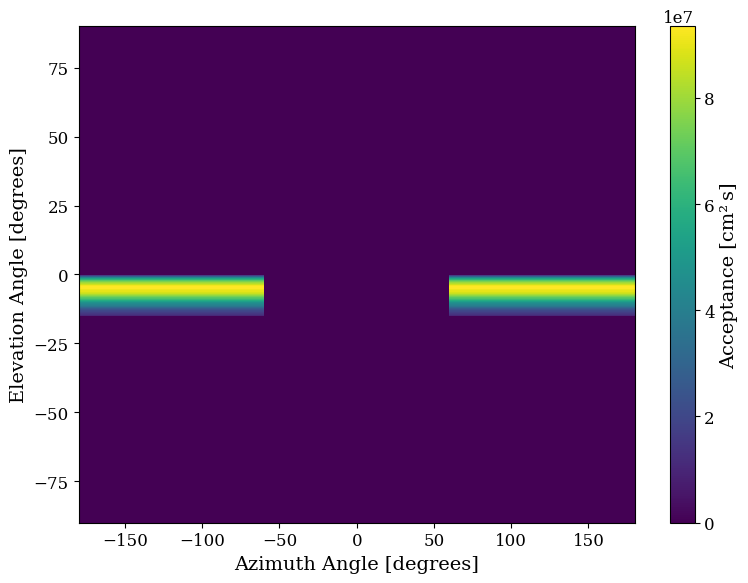

In [4]:
output_folder = 'acceptance_skymaps_output'

os.makedirs(output_folder, exist_ok=True)

f      = ROOT.TFile.Open("files/skyC.root")
canvas = f.Get("skyC")    # the TCanvas with two pads drawn side by side

# find only the sub‐pads.
all_prims = list(canvas.GetListOfPrimitives())
pads = [p for p in all_prims
        if p.ClassName() == "TPad" and p.GetName().startswith("skyC")]

# Inspect pad names
print("Found pads:", [p.GetName() for p in pads])

pad2 = next(p for p in pads if p.GetName() == "skyC_2")

# grab the TH2
hist2 = next(obj for obj in pad2.GetListOfPrimitives()
             if obj.InheritsFrom("TH2"))
if not hist2:
    raise RuntimeError("No TH2 found in pad_2!")

# extract bin contents & centers
nx, ny = hist2.GetNbinsX(), hist2.GetNbinsY()
accept2 = np.zeros((nx, ny))
for i in range(1, nx+1):
    for j in range(1, ny+1):
        accept2[i-1, j-1] = hist2.GetBinContent(i, j)

x_cent2 = np.array([hist2.GetXaxis().GetBinCenter(i) for i in range(1, nx+1)])
y_cent2 = np.array([hist2.GetYaxis().GetBinCenter(j) for j in range(1, ny+1)])

# plot
plt.figure(figsize=(8,6))
mesh = plt.pcolormesh(
    x_cent2,
    y_cent2,
    accept2.T,
    shading="auto"
)
plt.xlabel("Azimuth Angle [degrees]")
plt.ylabel("Elevation Angle [degrees]")
cbar = plt.colorbar(mesh)
cbar.set_label("Acceptance [cm² s]")
plt.tight_layout()
plt.show()

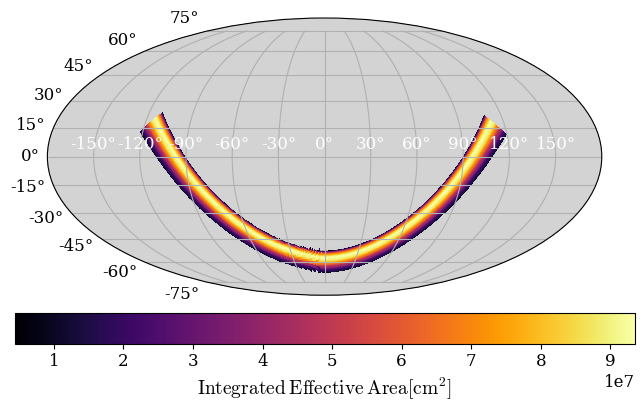

In [5]:
latitude_deg    = 38.5217                       # degrees
lst_hours       = 12.00                      # local sidereal time (hours)

# Converting to radians
lat_rad = np.radians(latitude_deg)
lst_rad = np.radians(lst_hours * 15.0)
# bin centers
x_centers = np.array([hist2.GetXaxis().GetBinCenter(i+1) for i in range(nx)])
y_centers = np.array([hist2.GetYaxis().GetBinCenter(j+1) for j in range(ny)])

# build and flatten grid
az_grid, el_grid = np.meshgrid(x_centers, y_centers, indexing='ij') #check if should be multiplied by -1, no because near the horizon should be better
az_flat = az_grid.ravel()
el_flat = el_grid.ravel()
acc_flat = accept2.ravel()


# convert
ras, decs = horiz_to_equatorial(az_flat, el_flat, lat_rad, lst_rad)
lon = np.pi - ras
lon = (lon + np.pi) % (2*np.pi) - np.pi

acc = acc_flat.copy()
pos = acc[acc > 0]
if pos.size == 0:
    raise ValueError("All values are non-positive; log color scale can't be used.")
vmin = float(pos.min())
vmax = float(acc.max())
acc_plot = acc.copy()
acc_plot[acc_plot <= 0] = vmin * 0.5

# cmap with white for masked values
cmap = plt.get_cmap('inferno').copy()
cmap.set_under('lightgray', alpha=0.8)


fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(8,4.5))
sc = ax.scatter(
    lon, decs,
    c=acc_plot,
    s=4, marker=",", linewidths=0, antialiased=False,
    cmap=cmap,
    vmin=vmin, vmax=vmax,
    rasterized=True
)

cb = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label(r'$\rm{Integrated\:Effective \: Area} [\rm{cm}^2]$')

ax.grid(True)
ax.tick_params(axis='x', colors='white')
out_name = f'skymap_instantaneous.png'
fig.savefig(os.path.join(output_folder, out_name), dpi=150)

plt.show()

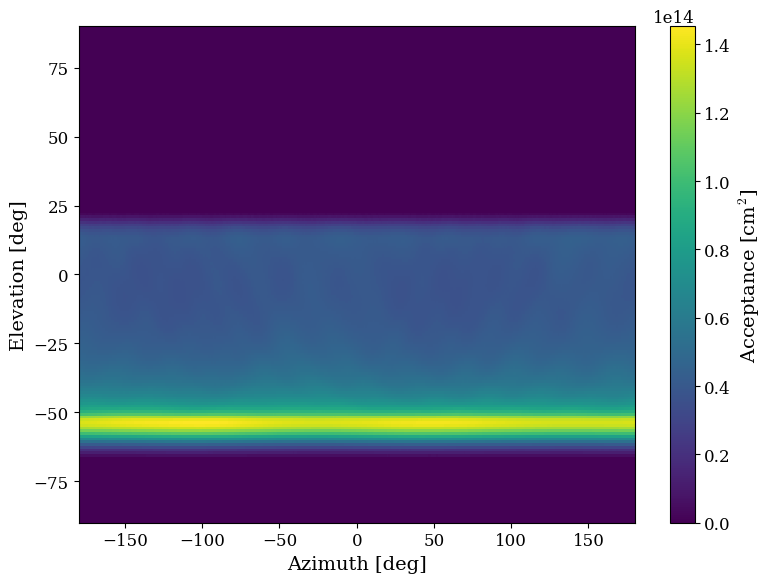

In [14]:

f = ROOT.TFile.Open(f"files/test1.root")
canvas = f.Get("test1")         # this is your TCanvas
prims   = canvas.GetListOfPrimitives()
h2 = next(obj for obj in prims if obj.InheritsFrom("TH2"))   # grab the first TH2 you find
if not h2:
    raise ValueError("Could not find 'test1' in the file.")

# Get binning info
nx = h2.GetNbinsX()
ny = h2.GetNbinsY()
    
# pull out just the bin contents into a (nx×ny) NumPy array
acceptance = np.zeros((nx, ny))
for i in range(1, nx+1):
    for j in range(1, ny+1):
        acceptance[i-1, j-1] = h2.GetBinContent(i, j)
    
# bin‐center coordinates
x_centers = np.array([h2.GetXaxis().GetBinCenter(i) for i in range(1, nx+1)])
y_centers = np.array([h2.GetYaxis().GetBinCenter(j) for j in range(1, ny+1)]) 

# now plot
plt.figure(figsize=(8,6))
mesh = plt.pcolormesh(
    x_centers,     # x bin edges
    y_centers,     # y bin edges
    acceptance.T,      # transpose so that data[:,j] aligns with y
    shading='auto'
)
plt.xlabel("Azimuth [deg]")
plt.ylabel("Elevation [deg]")
cbar = plt.colorbar(mesh)
cbar.set_label("Acceptance [cm$^2$]")
#plt.xlim([-30,30])
#plt.ylim([-15,0])
plt.tight_layout()
plt.show()

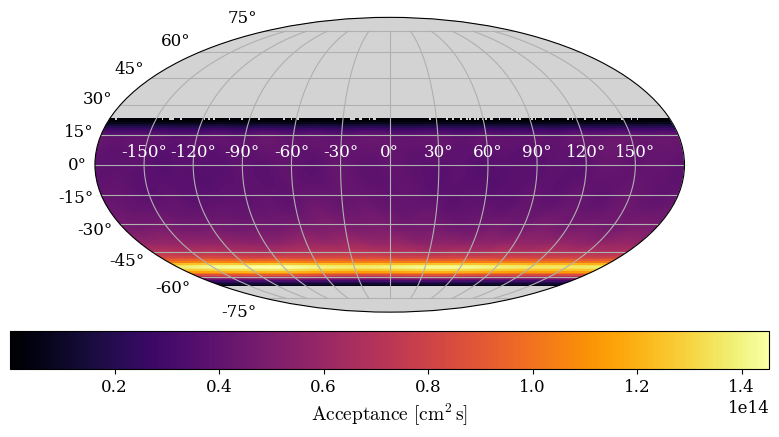

In [15]:
# Make meshgrid
ras, decs = np.meshgrid(x_centers, y_centers, indexing='xy')
ras_flat = ras.ravel()
decs_flat = decs.ravel()
acc_flat = acceptance.ravel()
lon = np.radians(ras)
lon = (lon + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]

# mask zero pixels
data = np.ma.masked_equal(acceptance.T, 0)

# make a copy and define masked as grey
cmap = plt.get_cmap("inferno").copy()
cmap.set_bad("lightgrey")

fig, ax = plt.subplots(subplot_kw=dict(projection="mollweide"), figsize=(8,4.5))
im = ax.pcolormesh(
    lon,
    np.radians(decs),
    data,
    shading="nearest",
    cmap=cmap
)

cb = fig.colorbar(im, ax=ax, orientation="horizontal", pad=0.05)
cb.set_label(r"$\rm{Acceptance}~[\rm{cm}^2\,\rm{s}]$")
ax.grid(True)
ax.tick_params(axis="x", colors="white")
out_name = f'skymap_instantaneous_1year.png'
fig.savefig(os.path.join(output_folder, out_name), dpi=150)
plt.tight_layout()
plt.show()

In [8]:

# Setup
latitude_deg = 38.5217                       # degrees
lst_hours    = 12.00                         # local sidereal time (hours)
lat_rad      = np.radians(latitude_deg)
lst0_rad     = np.radians(lst_hours * 15.0)  # convert H→°

# Time grid
t_total   = 8 * 3600      # total integration time in seconds
n_steps   = 400           # number of LST snapshots
times     = np.linspace(0, t_total, n_steps)
dt = times[1] - times[0]
omega_sid = 2 * np.pi / 86164.0905  # sidereal rate [rad/s]

# fixed horizon frame map
nx, ny = hist2.GetNbinsX(), hist2.GetNbinsY()
x_centers = np.array([hist2.GetXaxis().GetBinCenter(i+1) for i in range(nx)])
y_centers = np.array([hist2.GetYaxis().GetBinCenter(j+1) for j in range(ny)])
az_grid, el_grid = np.meshgrid(x_centers, y_centers, indexing='ij')
az_flat = az_grid.ravel()
el_flat = el_grid.ravel()
acc_flat   = accept2.ravel()    # instantaneous acceptance [arb.units]

#  empty equatorial histogram


n_ra_bins  = 6400
n_dec_bins = 3200
ra_bins  = np.linspace(-np.pi,   np.pi,   n_ra_bins+1)
dec_bins = np.linspace(-np.pi/2, np.pi/2, n_dec_bins+1)

# accumulator
H_acc = np.zeros((n_ra_bins, n_dec_bins))  # sum of acceptance

# Loop over time, rotate & accumulate
for t in tqdm(times):
    lst_rad = lst0_rad + omega_sid * t
    # turn (az,el)→(RA,Dec)
    ras, decs = horiz_to_equatorial(az_flat, el_flat, lat_rad, lst_rad)
    # adjust to Mollweide’s convention:
    lon_eq = np.pi - ras
    lon_eq = (lon_eq + np.pi) % (2*np.pi) - np.pi

    # accumulate acceptance
    H_step_acc, _, _ = np.histogram2d(
        lon_eq,
        decs,
        bins=[ra_bins, dec_bins],
        weights=acc_flat*dt
    )
    H_acc += H_step_acc



# Prepare for plotting: pixel centers
ra_centers  = 0.5 * (ra_bins[:-1]  + ra_bins[1:])
dec_centers = 0.5 * (dec_bins[:-1] + dec_bins[1:])
ra_grid, dec_grid = np.meshgrid(ra_centers, dec_centers, indexing='ij')

lon_avg      = ra_grid.ravel()
dec_avg      = dec_grid.ravel()
acc_alone = H_acc.ravel()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [07:40<00:00,  1.15s/it]


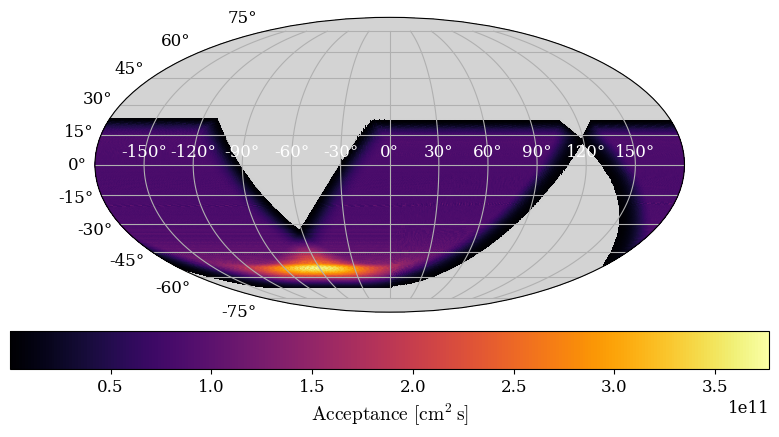

CPU times: user 8.72 s, sys: 428 ms, total: 9.15 s
Wall time: 9.15 s


In [16]:
%%time

# After the very high resolution defined for the time evolution the plotting can be slow so this makes the plotting faster by choosing the resolution

assert lon_avg.size == n_ra_bins * n_dec_bins
assert dec_avg.size == n_ra_bins * n_dec_bins
assert acc_alone.size == n_ra_bins * n_dec_bins

lon2d = lon_avg.reshape(n_ra_bins, n_dec_bins)       # RA (x) by Dec (y)
dec2d = dec_avg.reshape(n_ra_bins, n_dec_bins)
H2    = acc_alone.reshape(n_ra_bins, n_dec_bins)   # values on the grid

# choose plotting resolution (degrees)
reso_deg = 0.2 # try 2.0 or 5.0 

ra_step_deg  = 360.0 / n_ra_bins
dec_step_deg = 180.0 / n_dec_bins
fx = max(1, int(np.floor(reso_deg / ra_step_deg)))
fy = max(1, int(np.floor(reso_deg / dec_step_deg)))

# crop so reshape/slicing divides evenly
n_ra_c  = (n_ra_bins // fx) * fx
n_dec_c = (n_dec_bins // fy) * fy

lon_c = lon2d[:n_ra_c, :n_dec_c]
dec_c = dec2d[:n_ra_c, :n_dec_c]
H_c   = H2   [:n_ra_c, :n_dec_c]

# block-reduce values
H_ds = H_c.reshape(n_ra_c//fx, fx, n_dec_c//fy, fy).mean(axis=(1,3))
lon_ds = lon_c[::fx, ::fy]   # representative centers per block
dec_ds = dec_c[::fx, ::fy]

# Set up log color scaling using the downsampled values
pos = H_ds[H_ds > 0]
if pos.size == 0:
    raise ValueError("All values are non-positive; log color scale can't be used.")

vmin = float(pos.min())
vmax = float(H_ds.max())

# Use an "under" color for zeros (and any ≤0 values)
H_plot = H_ds.copy()
H_plot[H_plot <= 0] = vmin * 0.5  # ensures they go below vmin for 'under' color


cmap = plt.get_cmap('inferno').copy()
cmap.set_under('lightgray', alpha=0.8)

# Plot
fig, ax = plt.subplots(subplot_kw=dict(projection='mollweide'), figsize=(8, 4.5))
sc = ax.scatter(
    lon_ds.ravel(), dec_ds.ravel(),
    c=H_plot.ravel(),
    s=4, marker=",", linewidths=0, antialiased=False,
    cmap=cmap,
    vmin=vmin, vmax=vmax,   # linear scale 
    rasterized=True
)
cb = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05)
cb.set_label(r'$\rm{Acceptance}\ [\rm{cm}^2 \: \rm{s}]$')
ax.grid(True)
ax.tick_params(axis='x', colors='white')
plt.tight_layout()

# Save results
out_name = 'acceptance_daily.png'
fig.savefig(os.path.join(output_folder, out_name), dpi=150)

plt.show()